In [ ]:
# DEPENDENCIES
import json
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import os
import networkx as nx
import re  
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap


In [ ]:
# DATA LOAD
df = pd.read_excel(r'C:\Users\sandr\Documents\scrp_tiktok_tfg\analysis\Detection\detection_results\corrected_results_detections.xlsx')

def process_brand(brand):
    if pd.isna(brand):
        return []
    if isinstance(brand, str):
        return [brand.strip()]
    return [str(brand)] 

# Agrupar por 'id_urlvideo' y consolidar las marcas
df_grouped = df.groupby('id_urlvideo').agg({
    'brand_detected': lambda x: list(set([brand for brands in x.apply(process_brand) for brand in brands if brand]))
}).reset_index()

ruta_destino = r'C:\Users\sandr\Documents\scrp_tiktok_tfg\analysis\MBA\mba_results\groupedbyurl.xlsx'
df_grouped.to_excel(ruta_destino, index=False)
print(f'Archivo guardado en: {ruta_destino}')

df_transactions = df_grouped

In [ ]:
# Celda 3: Cargar JSON y datos agrupados
# CARGAR JSON Y EXCEL AGRUPADO 
json_file_path = r"C:\Users\sandr\Documents\scrp_tiktok_tfg\analysis\Detection\all_brands_products.json"
excel_file_path = r"C:\Users\sandr\Documents\scrp_tiktok_tfg\analysis\MBA\mba_results\groupedbyurl.xlsx"

with open(json_file_path, 'r', encoding='utf-8') as file:
    brands_products = json.load(file)
brand_names = list(brands_products.keys())
print(f"Total de marcas encontradas en el JSON: {len(brand_names)}")

df_transactions = pd.read_excel(excel_file_path)
print(f"Datos cargados del Excel. Forma: {df_transactions.shape}")
print(f"Columnas: {df_transactions.columns.tolist()}")

# Normalizar marcas (Nombres conflictivos)
brand_normalization = {
    "HUDA BEAUTY": "Huda Beauty",
    "Huda Beauty": "Huda Beauty",
    "DIOR": "Dior Beauty",
    "Dior Beauty": "Dior Beauty",
    "Rare Beauty by Selena Gomez": "Rare Beauty",
    "Rare Beauty": "Rare Beauty",
    "MAKEUP BY MARIO": "MAKEUP BY MARIO",
    "tarte": "tarte",
    "Tarte": "tarte"
}

Total de marcas encontradas en el JSON: 147
Datos cargados del Excel. Forma: (199, 2)
Columnas: ['id_urlvideo', 'brand_detected']


In [ ]:
# TRANSACCIONES
def extract_brands(brands_text):
    if not isinstance(brands_text, str):
        return []
    # Eliminar corchetes
    brands_text = brands_text.strip('[]')
    # Separar por comas pero teniendo en cuenta los nombres que llevan signos
    brands = []
    # Regrex para capturar nombres entre comillas o sin comillas
    pattern = r"'([^']+)'|\\\"([^\\\"]+)\\\"|([^,]+)"
    for match in re.finditer(pattern, brands_text):
        brand = next((g for g in match.groups() if g is not None), None)
        if brand:
            brand = brand.strip()
            if brand: 
                brands.append(brand)
    return brands

transactions = []

for index, row in df_transactions.iterrows():
    brands_list = extract_brands(row['brand_detected'])
    if brands_list: 
        transactions.append(brands_list)
print(f"Total de transacciones procesadas: {len(transactions)}")

normalized_transactions = []
for transaction in transactions:
    normalized_transaction = []
    for brand in transaction:
        brand = brand.strip("'\" ")
        normalized_brand = brand_normalization.get(brand, brand)
        normalized_transaction.append(normalized_brand)
    normalized_transaction = list(set(normalized_transaction))
    if normalized_transaction: 
        normalized_transactions.append(normalized_transaction)

Total de transacciones procesadas: 199


In [ ]:
# Frecuencia de cada marca
brand_counts = {}
for transaction in normalized_transactions:
    for brand in transaction:
        brand_counts[brand] = brand_counts.get(brand, 0) + 1

top_brands = sorted(brand_counts.items(), key=lambda x: x[1], reverse=True)[:15]
print("\nTop 15 marcas más frecuentes:")
for brand, count in top_brands:
    print(f"{brand}: {count} menciones")


Top 15 marcas más frecuentes:
Charlotte Tilbury: 119 menciones
Rare Beauty: 70 menciones
Make Up By Mario: 56 menciones
Huda Beauty: 51 menciones
Fenty Beauty: 46 menciones
Hourglass: 39 menciones
Dior Beauty: 39 menciones
NARS: 31 menciones
Benefit Cosmetics: 28 menciones
Too Faced: 26 menciones
Drunk Elephant: 25 menciones
Patrick Ta Beauty: 24 menciones
Anastasia Beverly Hills: 23 menciones
tarte: 19 menciones
Sol de Janeiro: 17 menciones


In [ ]:
# Conjuntos frecuentes con Algoritmo Apriori

# Convertir transacciones a formato binario con TransactionEncoder
te = TransactionEncoder()
te_ary = te.fit(normalized_transactions).transform(normalized_transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

# Ajustar el min_support - empezar con un valor mayor y luego si no reducir
min_support_values = [0.05, 0.03, 0.02, 0.01, 0.005]  # pruebas
frequent_itemsets = None

for min_support_value in min_support_values:
    print(f"\nBuscando conjuntos de ítems frecuentes con min_support = {min_support_value}...")
    try:
        frequent_itemsets = apriori(df, min_support=min_support_value, use_colnames=True)
        if len(frequent_itemsets) > 0:
            print(f"Se encontraron {len(frequent_itemsets)} conjuntos de ítems frecuentes.")
            break
    except Exception as e:
        print(f"Error con min_support={min_support_value}: {e}")

if frequent_itemsets is None or len(frequent_itemsets) == 0:
    print("No se pudieron encontrar conjuntos de ítems frecuentes. Usando el valor mínimo de soporte.")
    min_support_value = min(min_support_values)
    try:
        frequent_itemsets = apriori(df, min_support=min_support_value, use_colnames=True)
    except Exception as e:
        print(f"Error final: {e}")
        exit(1)

print(f"Conjuntos de ítems frecuentes encontrados: {len(frequent_itemsets)}")
if len(frequent_itemsets) > 0:
    print(frequent_itemsets.head())


Buscando conjuntos de ítems frecuentes con min_support = 0.05...
Se encontraron 84 conjuntos de ítems frecuentes.
Conjuntos de ítems frecuentes encontrados: 84
    support                   itemsets
0  0.115578  (Anastasia Beverly Hills)
1  0.140704        (Benefit Cosmetics)
2  0.050251              (Bobbi Brown)
3  0.597990        (Charlotte Tilbury)
4  0.195980              (Dior Beauty)


In [ ]:
# Rreglas de asociación
# Filtrar conjuntos frecuentes
frequent_itemsets_for_rules = frequent_itemsets

if len(frequent_itemsets_for_rules) > 0:
    try:
        rules = association_rules(frequent_itemsets_for_rules, metric="lift", min_threshold=0.5)
        print(f"\nReglas de asociación generadas: {len(rules)}")
        if len(rules) > 0:
            print(rules.head())
        else:
            print("No se generaron reglas de asociación con el umbral especificado.")
    except Exception as e:
        print(f"Error al generar reglas: {e}")


Reglas de asociación generadas: 178
                 antecedents                consequents  antecedent support  \
0  (Anastasia Beverly Hills)        (Charlotte Tilbury)            0.115578   
1        (Charlotte Tilbury)  (Anastasia Beverly Hills)            0.597990   
2  (Anastasia Beverly Hills)         (Make Up By Mario)            0.115578   
3         (Make Up By Mario)  (Anastasia Beverly Hills)            0.281407   
4        (Charlotte Tilbury)        (Benefit Cosmetics)            0.597990   

   consequent support   support  confidence      lift  representativity  \
0            0.597990  0.075377    0.652174  1.090610               1.0   
1            0.115578  0.075377    0.126050  1.090610               1.0   
2            0.281407  0.050251    0.434783  1.545031               1.0   
3            0.115578  0.050251    0.178571  1.545031               1.0   
4            0.140704  0.090452    0.151261  1.075030               1.0   

   leverage  conviction  zhangs_metri

In [ ]:
# Guardar resultados: 
results_dir = r"C:\Users\sandr\Documents\scrp_tiktok_tfg\analysis\MBA\mba_results"
os.makedirs(results_dir, exist_ok=True)

brand_freq_df = pd.DataFrame(brand_counts.items(), columns=['Brand', 'Frequency'])
brand_freq_df = brand_freq_df.sort_values('Frequency', ascending=False)
brand_freq_file = os.path.join(results_dir, "brand_frequencies.csv")
brand_freq_df.to_csv(brand_freq_file, index=False)
print(f"\nFrecuencias de marcas guardadas en: {brand_freq_file}")

# frequent_itemsets en CSV
if frequent_itemsets is not None and len(frequent_itemsets) > 0:
    frequent_itemsets_df = frequent_itemsets.copy()
    frequent_itemsets_df['itemsets_str'] = frequent_itemsets_df['itemsets'].apply(lambda x: ', '.join(list(x)))
    itemsets_file = os.path.join(results_dir, "frequent_itemsets.csv")
    frequent_itemsets_df.to_csv(itemsets_file, index=False)
    print(f"Conjuntos de ítems frecuentes guardados en: {itemsets_file}")

#  reglas en CSV (si hay reglas)
if len(rules) > 0:
    rules_df = rules.copy()
    rules_df['antecedents_str'] = rules_df['antecedents'].apply(lambda x: ', '.join(list(x)))
    rules_df['consequents_str'] = rules_df['consequents'].apply(lambda x: ', '.join(list(x)))
    rules_file = os.path.join(results_dir, "association_rules.csv")
    rules_df.to_csv(rules_file, index=False)
    print(f"Reglas guardadas en: {rules_file}")


Frecuencias de marcas guardadas en: C:\Users\sandr\Documents\scrp_tiktok_tfg\analysis\MBA\mba_results\brand_frequencies.csv
Conjuntos de ítems frecuentes guardados en: C:\Users\sandr\Documents\scrp_tiktok_tfg\analysis\MBA\mba_results\frequent_itemsets.csv
Reglas guardadas en: C:\Users\sandr\Documents\scrp_tiktok_tfg\analysis\MBA\mba_results\association_rules.csv


Gráfico de frecuencia de marcas guardado en: C:\Users\sandr\Documents\scrp_tiktok_tfg\analysis\MBA\mba_results\top_brands_frequency.png


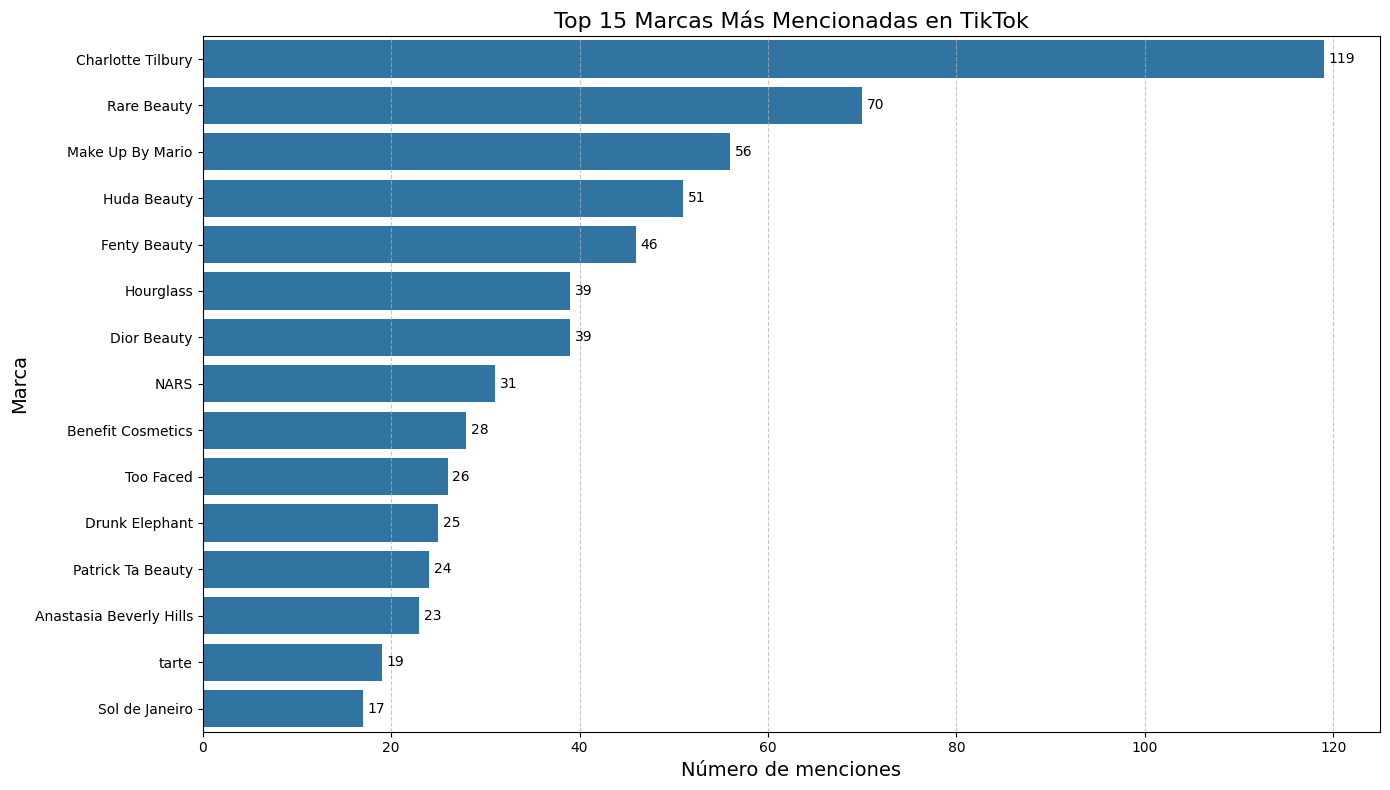

In [ ]:
# Gráfico de barras para top brands
plt.figure(figsize=(14, 8))
top_n = 15
top_brands_df = brand_freq_df.head(top_n)
ax = sns.barplot(x='Frequency', y='Brand', data=top_brands_df)
plt.title(f'Top {top_n} Marcas Más Mencionadas en TikTok', fontsize=16)
plt.xlabel('Número de menciones', fontsize=14)
plt.ylabel('Marca', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)

for i, v in enumerate(top_brands_df['Frequency']):
    ax.text(v + 0.5, i, str(v), va='center')

brands_chart_file = os.path.join(results_dir, "top_brands_frequency.png")
plt.tight_layout()
plt.savefig(brands_chart_file, dpi=300)
print(f"Gráfico de frecuencia de marcas guardado en: {brands_chart_file}")

Matriz de co-ocurrencia guardada en: C:\Users\sandr\Documents\scrp_tiktok_tfg\analysis\MBA\mba_results\brand_cooccurrence_matrix.csv
Mapa de calor guardado en: C:\Users\sandr\Documents\scrp_tiktok_tfg\analysis\MBA\mba_results\brands_cooccurrence_heatmap.png


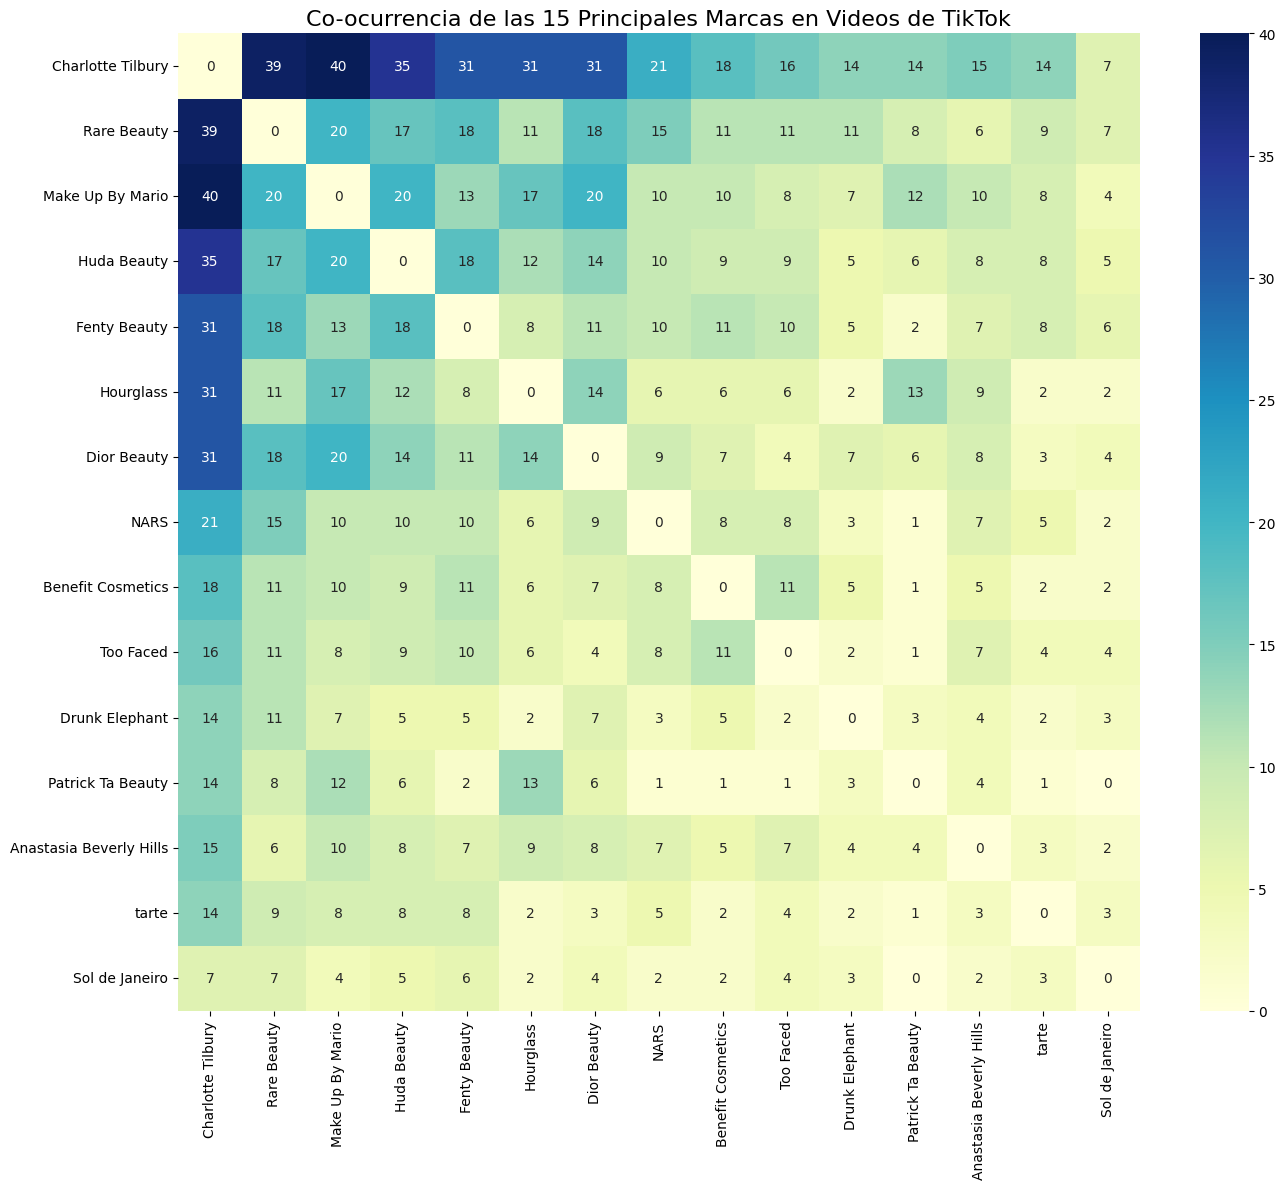

In [ ]:
# Matriz de co-ocurrencia con todas las marcas
all_brands_list = list(brand_counts.keys())
cooccurrence_matrix = np.zeros((len(all_brands_list), len(all_brands_list)))

for i, brand1 in enumerate(all_brands_list):
    for j, brand2 in enumerate(all_brands_list):
        if i != j:
            cooccurrence = 0
            for transaction in normalized_transactions:
                if brand1 in transaction and brand2 in transaction:
                    cooccurrence += 1
            cooccurrence_matrix[i, j] = cooccurrence

cooccurrence_df = pd.DataFrame(cooccurrence_matrix, index=all_brands_list, columns=all_brands_list)

cooccurrence_file = os.path.join(results_dir, "brand_cooccurrence_matrix.csv")
cooccurrence_df.to_csv(cooccurrence_file)
print(f"Matriz de co-ocurrencia guardada en: {cooccurrence_file}")

# Matriz de co-ocurrencia para las 15 marcas más mencionadas
plt.figure(figsize=(14, 12))
top15_brands = brand_freq_df.head(15)['Brand'].tolist()
sns.heatmap(cooccurrence_df.loc[top15_brands, top15_brands], annot=True, cmap="YlGnBu", fmt='g')
plt.title('Co-ocurrencia de las 15 Principales Marcas en Videos de TikTok', fontsize=16)
plt.tight_layout()
heatmap_file = os.path.join(results_dir, "brands_cooccurrence_heatmap.png")
plt.savefig(heatmap_file, dpi=300)
print(f"Mapa de calor guardado en: {heatmap_file}")

In [ ]:
excel_results_file = os.path.join(results_dir, "market_basket_analysis_results.xlsx")

with pd.ExcelWriter(excel_results_file, engine='openpyxl') as writer:
    # Hoja 1: Frecuencia de marcas
    brand_freq_df = pd.DataFrame(brand_counts.items(), columns=['Brand', 'Frequency'])
    brand_freq_df['Support'] = brand_freq_df['Frequency'] / len(normalized_transactions)
    brand_freq_df['Percentage'] = brand_freq_df['Support'] * 100
    brand_freq_df = brand_freq_df.sort_values('Frequency', ascending=False)
    brand_freq_df.to_excel(writer, sheet_name='Brand_Frequencies', index=False)
    # Hoja 2: Itemsets frecuentes
    if frequent_itemsets is not None and len(frequent_itemsets) > 0:
        frequent_itemsets_df = frequent_itemsets.copy()
        frequent_itemsets_df['itemsets_str'] = frequent_itemsets_df['itemsets'].apply(lambda x: ', '.join(list(x)))
        frequent_itemsets_df['itemset_size'] = frequent_itemsets_df['itemsets'].apply(len)
        frequent_itemsets_df['transactions_count'] = (frequent_itemsets_df['support'] * len(normalized_transactions)).astype(int)
        frequent_itemsets_df = frequent_itemsets_df.sort_values(['itemset_size', 'support'], ascending=[True, False])
        frequent_itemsets_df.to_excel(writer, sheet_name='Frequent_Itemsets', index=False)
    
    # Hoja 3-5: Reglas de asociación (si hay reglas generadas)
    if rules is not None and len(rules) > 0:
        try:
            rules_df = rules.copy()
            rules_df['antecedents_str'] = rules_df['antecedents'].apply(lambda x: ', '.join(list(x)))
            rules_df['consequents_str'] = rules_df['consequents'].apply(lambda x: ', '.join(list(x)))
            rules_df['transactions_count'] = (rules_df['support'] * len(normalized_transactions)).astype(int)

            if 'confidence' in rules_df.columns:
                rules_df['confidence_pct'] = rules_df['confidence'] * 100
            
            rules_df.to_excel(writer, sheet_name='Association_Rules', index=False)
            
            # Hoja 4: Top reglas por lift
            if 'lift' in rules_df.columns:
                top_rules = rules_df.sort_values('lift', ascending=False).head(30).copy()
                top_rules.to_excel(writer, sheet_name='Top_Rules_by_Lift', index=False)
            
            # Hoja 5: Top reglas por confianza
            if 'confidence' in rules_df.columns:
                top_conf_rules = rules_df.sort_values('confidence', ascending=False).head(30).copy()
                top_conf_rules.to_excel(writer, sheet_name='Top_Rules_by_Confidence', index=False)
        except Exception as e:
            print(f"Error al guardar las reglas en Excel: {e}")
            # Crear una hoja con mensaje informativo
            pd.DataFrame({'Mensaje': ['No se pudieron procesar las reglas de asociación correctamente']}).to_excel(
                writer, sheet_name='Reglas_Info', index=False)
    else:
        pd.DataFrame({'Mensaje': ['No se generaron reglas de asociación']}).to_excel(
            writer, sheet_name='Reglas_Info', index=False)
    
    # Hoja 6: Matriz de co-ocurrencia
    top50_brands_df = brand_freq_df.head(50)
    top50_brands_list = top50_brands_df['Brand'].tolist()
    cooccurrence_df_top50 = cooccurrence_df.loc[top50_brands_list, top50_brands_list]
    cooccurrence_df_top50.to_excel(writer, sheet_name='Cooccurrence_Matrix_Top50')
    
    # Hoja 7: Matriz de co-ocurrencia completa en una hoja separada
    cooccurrence_df.to_excel(writer, sheet_name='Cooccurrence_Matrix_Full')
    
    # Hoja 8: Guía de métricas MBA
    metrics_explanation = {
        'Métrica': [
            'Support (Soporte)', 
            'Confidence (Confianza)', 
            'Lift',
            'Leverage',
            'Conviction'
        ],
        'Explicación': [
            'Proporción de transacciones que contienen tanto el antecedente como el consecuente. Indica la frecuencia de la regla.',
            'Probabilidad condicional de que ocurra el consecuente dado el antecedente. Mide la fuerza de la implicación.',
            'Ratio entre la probabilidad observada y la esperada si los ítems fueran independientes. Lift > 1 indica asociación positiva.',
            'Diferencia entre la probabilidad observada y la esperada. Valores positivos indican asociación positiva.',
            'Mide cuánto depende el consecuente del antecedente. Valores altos indican dependencia fuerte.'
        ],
        'Fórmula': [
            'support(A→B) = P(A ∩ B)',
            'confidence(A→B) = P(B|A) = support(A→B) / support(A)',
            'lift(A→B) = confidence(A→B) / support(B)',
            'leverage(A→B) = support(A→B) - support(A) × support(B)',
            'conviction(A→B) = (1 - support(B)) / (1 - confidence(A→B))'
        ],
        'Interpretación': [
            'Un soporte alto indica que la regla es frecuente en los datos.',
            'Una confianza alta indica que la regla tiene alta precisión.',
            'Lift > 1: Asociación positiva, Lift < 1: Asociación negativa, Lift = 1: Independencia.',
            'Valores positivos indican que los items aparecen juntos más de lo esperado.',
            'Valores altos indican reglas más interesantes.'
        ]
    }
    
    pd.DataFrame(metrics_explanation).to_excel(writer, sheet_name='MBA_Metrics_Guide', index=False)

print(f"\nTodos los resultados del análisis han sido guardados en: {excel_results_file}")


Todos los resultados del análisis han sido guardados en: C:\Users\sandr\Documents\scrp_tiktok_tfg\analysis\MBA\mba_results\market_basket_analysis_results.xlsx


Matriz de lift guardada en: C:\Users\sandr\Documents\scrp_tiktok_tfg\analysis\MBA\mba_results\brand_lift_matrix.csv
Mapa de calor de lift guardado en: C:\Users\sandr\Documents\scrp_tiktok_tfg\analysis\MBA\mba_results\brands_lift_heatmap.png
Análisis de Market Basket completado con éxito. Todos los resultados se han guardado en el directorio de resultados.


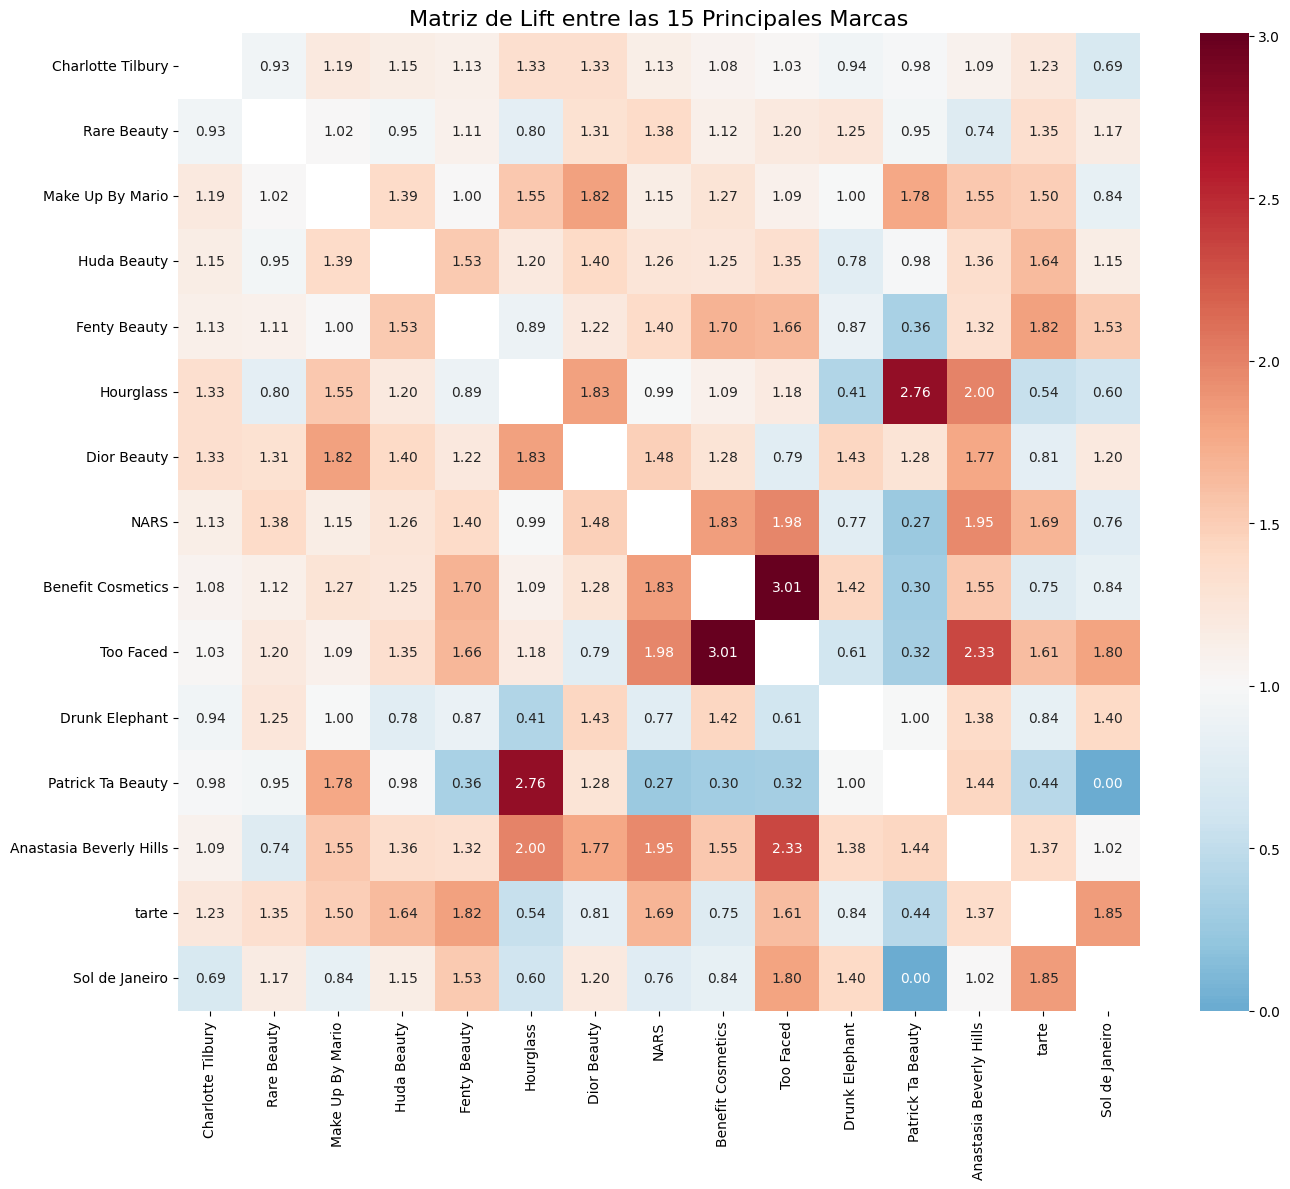

In [ ]:
# Mtriz de lift para todas las marcas
lift_matrix = np.zeros((len(all_brands_list), len(all_brands_list)))

for i, brand1 in enumerate(all_brands_list):
    for j, brand2 in enumerate(all_brands_list):
        if i != j:
            # Apariciones individuales:
            count1 = brand_counts.get(brand1, 0)
            count2 = brand_counts.get(brand2, 0)
            
            # Co-ocurrencias:
            cooccurrence = 0
            for transaction in normalized_transactions:
                if brand1 in transaction and brand2 in transaction:
                    cooccurrence += 1
            
            # Calcular lift (evitar división por cero):
            if count1 > 0 and count2 > 0:
                support1 = count1 / len(normalized_transactions)
                support2 = count2 / len(normalized_transactions)
                support_pair = cooccurrence / len(normalized_transactions)
                lift_value = support_pair / (support1 * support2) if (support1 * support2) > 0 else 0
                lift_matrix[i, j] = lift_value

lift_df = pd.DataFrame(lift_matrix, index=all_brands_list, columns=all_brands_list)

lift_file = os.path.join(results_dir, "brand_lift_matrix.csv")
lift_df.to_csv(lift_file)
print(f"Matriz de lift guardada en: {lift_file}")

with pd.ExcelWriter(excel_results_file, mode='a', engine='openpyxl') as writer:
    lift_df_top50 = lift_df.loc[top50_brands_list, top50_brands_list]
    lift_df_top50.to_excel(writer, sheet_name='Lift_Matrix_Top50')
    lift_df.to_excel(writer, sheet_name='Lift_Matrix_Full')


# Visualizar matriz de lift para las 15 marcas principales
plt.figure(figsize=(14, 12))
mask = np.zeros_like(lift_df.loc[top15_brands, top15_brands])
np.fill_diagonal(mask, 1)  # Marcar la diagonal principal para no mostrarla
sns.heatmap(lift_df.loc[top15_brands, top15_brands], annot=True, cmap="RdBu_r", center=1, mask=mask, fmt='.2f')
plt.title('Matriz de Lift entre las 15 Principales Marcas', fontsize=16)
plt.tight_layout()
lift_heatmap_file = os.path.join(results_dir, "brands_lift_heatmap.png")
plt.savefig(lift_heatmap_file, dpi=300)
print(f"Mapa de calor de lift guardado en: {lift_heatmap_file}")

print("Análisis de Market Basket completado con éxito. Todos los resultados se han guardado en el directorio de resultados.")

Visualización estática mejorada del grafo guardada en: C:\Users\sandr\Documents\scrp_tiktok_tfg\analysis\MBA\mba_results\brand_network_beautiful_static.png
Visualización interactiva con D3.js (15 marcas) guardada en: C:\Users\sandr\Documents\scrp_tiktok_tfg\analysis\MBA\mba_results\html\brand_network_beautiful_top15.html
Visualización interactiva con D3.js (20 marcas) guardada en: C:\Users\sandr\Documents\scrp_tiktok_tfg\analysis\MBA\mba_results\html\brand_network_beautiful_top20.html
Información de las visualizaciones guardada en: C:\Users\sandr\Documents\scrp_tiktok_tfg\analysis\MBA\mba_results\visualizations_info.csv
Visualizaciones mejoradas creadas con éxito.


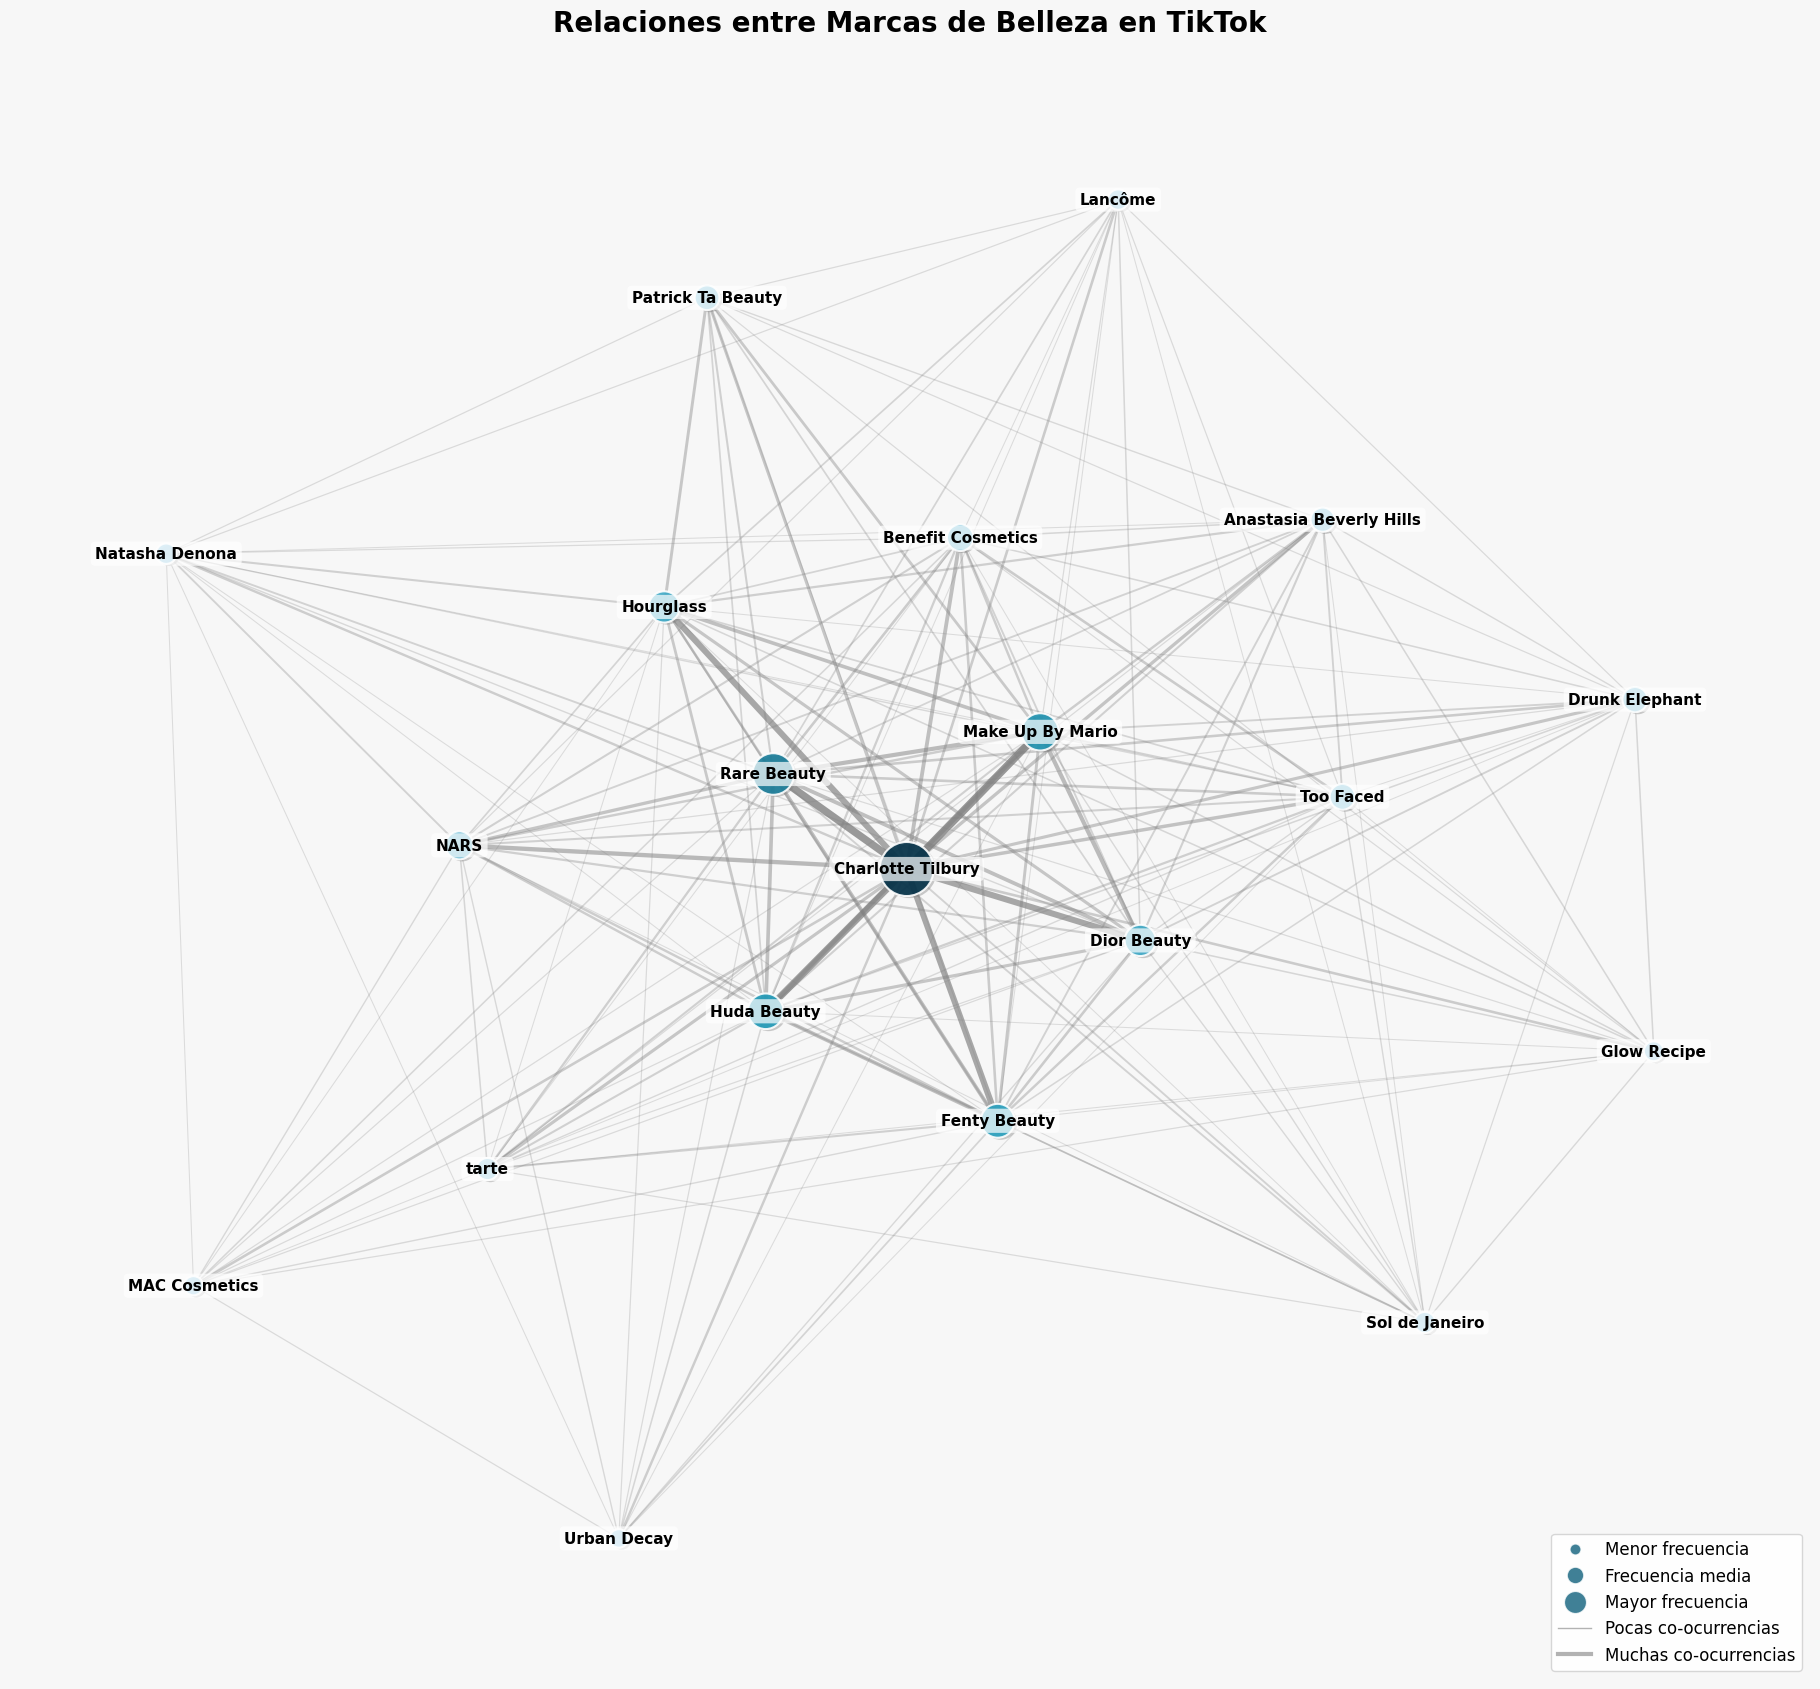

In [15]:
# Grafo de relaciones entre marcas

# Función para hacer que los valores de numpy sean serializables en JSON
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NumpyEncoder, self).default(obj)

html_dir = os.path.join(results_dir, "html")
os.makedirs(html_dir, exist_ok=True)

def create_beautiful_static_network(cooccurrence_df, brand_freq_df, top_n=20, min_connections=2, save_path=None):
    # Marcas frecuentes
    top_brands = brand_freq_df.head(top_n)['Brand'].tolist()
    G = nx.Graph()
    # Agregar nodos (marcas)
    for brand in top_brands:
        # Tamaño del nodo según frecuencia de la marca
        freq = brand_freq_df.loc[brand_freq_df['Brand'] == brand, 'Frequency'].values[0]
        freq_int = int(freq)
        G.add_node(brand, freq=freq_int)
    
    # Aristas (relaciones entre marcas)
    for i, brand1 in enumerate(top_brands):
        for j, brand2 in enumerate(top_brands):
            if i < j:  
                if brand1 in cooccurrence_df.index and brand2 in cooccurrence_df.columns:
                    try:
                        cooccurrence_count = cooccurrence_df.loc[brand1, brand2]
                        if not pd.isna(cooccurrence_count) and cooccurrence_count >= min_connections:
                            weight = int(cooccurrence_count)
                            G.add_edge(brand1, brand2, weight=weight)
                    except Exception as e:
                        print(f"Error accediendo a co-ocurrencia entre {brand1} y {brand2}: {e}")
    
    plt.figure(figsize=(20, 18), facecolor='#f7f7f7')
    plt.tight_layout()
    pos = nx.spring_layout(G, k=0.3, iterations=100, seed=42)
    cmap = LinearSegmentedColormap.from_list('custom_blues', ["#8ecae6", "#219ebc", "#126782", "#023047"], N=256)

    # Frecuencias de nodos para tamaño y color
    node_freqs = [G.nodes[node]['freq'] for node in G.nodes()]
    node_sizes = [15 + (freq / max(node_freqs)) * 1500 for freq in node_freqs]
    node_colors = [freq / max(node_freqs) for freq in node_freqs]

    nodes = nx.draw_networkx_nodes(G, pos, 
                                 node_size=node_sizes, 
                                 node_color=node_colors, 
                                 cmap=cmap, 
                                 alpha=0.9,
                                 linewidths=1.5,
                                 edgecolors='white')
    for i, (node, position) in enumerate(pos.items()):
        plt.scatter(position[0]+0.003, position[1]-0.003, s=node_sizes[i], alpha=0.4, c='gray', edgecolors='none')
    edge_weights = [G.edges[edge]['weight'] for edge in G.edges()]
    max_weight = max(edge_weights) if edge_weights else 1
    edge_widths = [0.5 + (weight / max_weight) * 5 for weight in edge_weights]
    edge_alphas = [0.2 + 0.6 * (weight / max_weight) for weight in edge_weights]

    # Dibujar aristas con gradiente basado en peso
    edges = nx.draw_networkx_edges(G, pos, 
                                 width=edge_widths, 
                                 alpha=edge_alphas, 
                                 edge_color='gray', 
                                 style='solid')

    labels = nx.draw_networkx_labels(G, pos, 
                                 font_size=11, 
                                 font_family='sans-serif', 
                                 font_weight='bold',
                                 bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3', alpha=0.7))

    plt.title('Relaciones entre Marcas de Belleza en TikTok', fontsize=20, fontweight='bold', pad=20, fontfamily='sans-serif')
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(0.7), markersize=8, alpha=0.8, label='Menor frecuencia'),
              plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(0.7), markersize=12, alpha=0.8, label='Frecuencia media'),
              plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(0.7), markersize=16, alpha=0.8, label='Mayor frecuencia')]
    handles.extend([plt.Line2D([0], [0], color='gray', lw=1, alpha=0.6, label='Pocas co-ocurrencias'),
                   plt.Line2D([0], [0], color='gray', lw=3, alpha=0.6, label='Muchas co-ocurrencias')])

    plt.legend(handles=handles, loc='lower right', fontsize=12, frameon=True, framealpha=0.9, facecolor='white', edgecolor='lightgray')

    plt.axis('off')
    plt.tight_layout()
    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight", facecolor='white')
    
    return G, plt

def export_network_data_for_html(cooccurrence_df, brand_freq_df, top_n=15, min_connections=3, json_path=None):
    top_brands = brand_freq_df.head(top_n)['Brand'].tolist()
    # Crear estructura de datos para el grafo
    nodes = []
    links = []
    
    # Nodos:
    for brand in top_brands:
        freq = int(brand_freq_df.loc[brand_freq_df['Brand'] == brand, 'Frequency'].values[0])
        nodes.append({
            "id": brand,
            "label": brand,
            "size": 15 + (freq / int(brand_freq_df['Frequency'].max())) * 35,
            "title": f"{brand}: {freq} menciones",
            "frequency": freq
        })
    
    # Valor máximo de co-ocurrencia para normalización
    max_cooccurrence = 0
    for i, brand1 in enumerate(top_brands):
        for j, brand2 in enumerate(top_brands):
            if i < j and brand1 in cooccurrence_df.index and brand2 in cooccurrence_df.columns:
                try:
                    cooccurrence_count = int(cooccurrence_df.loc[brand1, brand2])
                    if not pd.isna(cooccurrence_count) and cooccurrence_count >= min_connections:
                        max_cooccurrence = max(max_cooccurrence, cooccurrence_count)
                except Exception:
                    pass
    
    # Eenlaces
    for i, brand1 in enumerate(top_brands):
        for j, brand2 in enumerate(top_brands):
            if i < j:  # Evitar duplicados
                if brand1 in cooccurrence_df.index and brand2 in cooccurrence_df.columns:
                    try:
                        cooccurrence_count = int(cooccurrence_df.loc[brand1, brand2])
                        if not pd.isna(cooccurrence_count) and cooccurrence_count >= min_connections:
                            width = 1 + (cooccurrence_count / max_cooccurrence) * 7
                            links.append({
                                "source": brand1,
                                "target": brand2,
                                "value": cooccurrence_count,
                                "width": width,
                                "title": f"{brand1} ↔ {brand2}: {cooccurrence_count} co-ocurrencias"
                            })
                    except Exception as e:
                        print(f"Error accediendo a co-ocurrencia entre {brand1} y {brand2}: {e}")
    graph_data = {
        "nodes": nodes,
        "links": links
    }
    
    if json_path:
        with open(json_path, 'w', encoding='utf-8') as f:
            json.dump(graph_data, f, ensure_ascii=False, indent=2, cls=NumpyEncoder)
    
    return graph_data

def create_html_visualization(json_path, html_path, title="Relaciones entre Marcas"):
    """
    Crear un archivo HTML con una visualización D3.js del grafo
    """
    html_content = f"""<!DOCTYPE html>
<html>
<head>
    <meta charset="utf-8">
    <title>{title}</title>
    <style>
        body {{
            font-family: Arial, sans-serif;
            margin: 0;
            padding: 0;
            background-color: #f8f9fa;
        }}
        #chart-container {{
            width: 100%;
            height: 800px;
            margin: 0 auto;
        }}
        .node {{
            stroke: #fff;
            stroke-width: 1.5px;
        }}
        .link {{
            stroke: #999;
            stroke-opacity: 0.6;
        }}
        .node text {{
            pointer-events: none;
            font-size: 10px;
        }}
        .title {{
            text-align: center;
            padding: 20px;
            font-size: 24px;
            font-weight: bold;
            color: #333;
        }}
    </style>
</head>
<body>
    <div class="title">{title}</div>
    <div id="chart-container"></div>

    <script src="https://d3js.org/d3.v5.min.js"></script>
    <script>
        // Cargar los datos del grafo
        fetch('{os.path.basename(json_path)}')
            .then(response => response.json())
            .then(data => {{
                createForceGraph(data);
            }});

        function createForceGraph(graph) {{
            const width = document.getElementById('chart-container').clientWidth;
            const height = document.getElementById('chart-container').clientHeight;

            // Crear la simulación de fuerzas
            const simulation = d3.forceSimulation(graph.nodes)
                .force("link", d3.forceLink(graph.links).id(d => d.id).distance(100))
                .force("charge", d3.forceManyBody().strength(-300))
                .force("center", d3.forceCenter(width / 2, height / 2))
                .force("collide", d3.forceCollide(d => d.size / 2 + 10));

            // Crear el elemento SVG
            const svg = d3.select("#chart-container").append("svg")
                .attr("width", width)
                .attr("height", height);

            // Definir gradiente de color para los nodos
            const defs = svg.append("defs");
            const blueGradient = defs.append("linearGradient")
                .attr("id", "blueGradient")
                .attr("x1", "0%")
                .attr("y1", "0%")
                .attr("x2", "100%")
                .attr("y2", "100%");

            blueGradient.append("stop")
                .attr("offset", "0%")
                .attr("stop-color", "#8ecae6");

            blueGradient.append("stop")
                .attr("offset", "100%")
                .attr("stop-color", "#023047");

            // Agregar sombras
            const filter = defs.append("filter")
                .attr("id", "drop-shadow")
                .attr("height", "130%");

            filter.append("feGaussianBlur")
                .attr("in", "SourceAlpha")
                .attr("stdDeviation", 3)
                .attr("result", "blur");

            filter.append("feOffset")
                .attr("in", "blur")
                .attr("dx", 3)
                .attr("dy", 3)
                .attr("result", "offsetBlur");

            const feMerge = filter.append("feMerge");
            feMerge.append("feMergeNode")
                .attr("in", "offsetBlur");
            feMerge.append("feMergeNode")
                .attr("in", "SourceGraphic");

            // Crear enlaces
            const link = svg.append("g")
                .selectAll("line")
                .data(graph.links)
                .enter().append("line")
                .attr("stroke-width", d => d.width)
                .attr("stroke", "#999")
                .attr("stroke-opacity", 0.6);

            // Crear grupos para nodos
            const node = svg.append("g")
                .selectAll(".node")
                .data(graph.nodes)
                .enter().append("g")
                .attr("class", "node")
                .call(d3.drag()
                    .on("start", dragstarted)
                    .on("drag", dragged)
                    .on("end", dragended));

            // Agregar círculos a los nodos
            const maxFreq = d3.max(graph.nodes, d => d.frequency);
            const colorScale = d3.scaleLinear()
                .domain([0, maxFreq])
                .range([0, 1]);

            node.append("circle")
                .attr("r", d => d.size / 2)
                .attr("fill", d => {{
                    const colorIndex = Math.floor(colorScale(d.frequency) * 4);
                    const colors = ["#8ecae6", "#219ebc", "#126782", "#023047"];
                    return colors[Math.min(colorIndex, 3)];
                }})
                .attr("stroke", "#fff")
                .attr("stroke-width", 1.5)
                .attr("filter", "url(#drop-shadow)")
                .append("title")
                .text(d => d.title);

            // Agregar etiquetas a los nodos
            node.append("text")
                .attr("dx", d => d.size / 2 + 5)
                .attr("dy", ".35em")
                .text(d => d.label)
                .attr("font-size", 12)
                .attr("font-weight", "bold")
                .attr("stroke", "white")
                .attr("stroke-width", 3)
                .attr("stroke-opacity", 0.8)
                .attr("paint-order", "stroke")
                .attr("fill", "#333");

            // Agregar tooltips para enlaces
            link.append("title")
                .text(d => d.title);

            // Actualizar posiciones en cada tick de la simulación
            simulation.on("tick", () => {{
                link
                    .attr("x1", d => d.source.x)
                    .attr("y1", d => d.source.y)
                    .attr("x2", d => d.target.x)
                    .attr("y2", d => d.target.y);

                node.attr("transform", d => `translate(${{d.x}},${{d.y}})`);
            }});

            // Funciones para el arrastre de nodos
            function dragstarted(d) {{
                if (!d3.event.active) simulation.alphaTarget(0.3).restart();
                d.fx = d.x;
                d.fy = d.y;
            }}

            function dragged(d) {{
                d.fx = d3.event.x;
                d.fy = d3.event.y;
            }}

            function dragended(d) {{
                if (!d3.event.active) simulation.alphaTarget(0);
                d.fx = null;
                d.fy = null;
            }}
        }}
    </script>
</body>
</html>
    """
    
    with open(html_path, 'w', encoding='utf-8') as f:
        f.write(html_content)
        
    return html_path

static_network_file = os.path.join(results_dir, "brand_network_beautiful_static.png")
G, plt_obj = create_beautiful_static_network(
    cooccurrence_df, 
    brand_freq_df, 
    top_n=20, 
    min_connections=2,
    save_path=static_network_file
)
print(f"Visualización estática mejorada del grafo guardada en: {static_network_file}")

json_path_15 = os.path.join(html_dir, "graph_data_top15.json")
html_path_15 = os.path.join(html_dir, "brand_network_beautiful_top15.html")

graph_data_15 = export_network_data_for_html(
    cooccurrence_df, 
    brand_freq_df, 
    top_n=15, 
    min_connections=3, 
    json_path=json_path_15
)

create_html_visualization(
    json_path_15, 
    html_path_15, 
    title="Relaciones entre las 15 Marcas de Belleza Principales en TikTok"
)
print(f"Visualización interactiva con D3.js (15 marcas) guardada en: {html_path_15}")

json_path_20 = os.path.join(html_dir, "graph_data_top20.json")
html_path_20 = os.path.join(html_dir, "brand_network_beautiful_top20.html")

graph_data_20 = export_network_data_for_html(
    cooccurrence_df, 
    brand_freq_df, 
    top_n=20, 
    min_connections=2, 
    json_path=json_path_20
)

create_html_visualization(
    json_path_20, 
    html_path_20, 
    title="Relaciones entre las 20 Marcas de Belleza Principales en TikTok"
)
print(f"Visualización interactiva con D3.js (20 marcas) guardada en: {html_path_20}")

visualizations_info = {
    'Visualización': [
        'Grafo interactivo D3.js (20 marcas)',
        'Grafo interactivo D3.js (15 marcas)',
        'Grafo estático mejorado'
    ],
    'Archivo': [
        html_path_20,
        html_path_15,
        static_network_file
    ],
    'Descripción': [
        'Visualización interactiva con D3.js de las 20 marcas más mencionadas (mín. 2 co-ocurrencias)',
        'Visualización interactiva con D3.js de las 15 marcas principales (mín. 3 co-ocurrencias)',
        'Imagen estática mejorada del grafo de relaciones para incluir en informes'
    ]
}

# Guardar información en CSV
vis_info_df = pd.DataFrame(visualizations_info)
vis_info_file = os.path.join(results_dir, "visualizations_info.csv")
vis_info_df.to_csv(vis_info_file, index=False)
print(f"Información de las visualizaciones guardada en: {vis_info_file}")

print("Visualizaciones mejoradas creadas con éxito.")

## 📊 Diferencia entre Matriz de Co-ocurrencia y Matriz de Lift

En el análisis de asociación entre pares de marcas, es común trabajar con **matrices de co-ocurrencia** y **matrices de lift**. Aunque ambas están relacionadas con la asociación entre marcas, representan medidas distintas y tienen interpretaciones diferentes.

---

### Matriz de Co-ocurrencia  
- ✅ **Mide frecuencia absoluta** → Indica cuántas veces aparecen juntas dos marcas.  
- ✅ Es una **medida de conteo simple** → No tiene en cuenta la popularidad individual de cada marca.  
- ✅ Los valores son **números enteros** → Directamente basados en la frecuencia de aparición conjunta.  

👉 **Ejemplo:** Si las marcas A y B aparecen juntas en 100 videos, el valor de co-ocurrencia será 100.

---

### Matriz de Lift  
- ✅ **Mide asociación relativa** → Ajusta la co-ocurrencia en función de la popularidad individual de cada marca.  
- ✅ La fórmula es:  
\[
\text{lift}(A, B) = \frac{P(A, B)}{P(A) \times P(B)}
\]
donde:  
- \(P(A, B)\) = Probabilidad de que A y B aparezcan juntas  
- \(P(A)\) = Probabilidad de que aparezca A  
- \(P(B)\) = Probabilidad de que aparezca B  

- ✅ **Interpretación de valores:**
  - **Lift > 1** → Asociación positiva (más probable que aparezcan juntas de lo esperado).  
  - **Lift = 1** → Independencia (sin asociación).  
  - **Lift < 1** → Asociación negativa (menos probable que aparezcan juntas de lo esperado).  

 **Ejemplo:** Si las marcas A y B aparecen juntas más de lo esperado considerando su popularidad individual, el lift será mayor a 1.

---

### Ejemplo para entender la diferencia  
Supongamos dos casos:

1. **Caso 1:**  
- Marca A → Aparece en el **80%** de los videos.  
- Marca B → Aparece en el **70%** de los videos.  
- A y B aparecen juntas en el **60%** de los videos.  

➡️ **Lift(A, B):**  
\[
\frac{0.60}{0.80 \times 0.70} = \frac{0.60}{0.56} = 1.07 \quad (\text{asociación ligeramente positiva})
\]

2. **Caso 2:**  
- Marca C → Aparece en el **10%** de los videos.  
- Marca D → Aparece en el **5%** de los videos.  
- C y D aparecen juntas en el **4%** de los videos.  

➡️ **Lift(C, D):**  
\[
\frac{0.04}{0.10 \times 0.05} = \frac{0.04}{0.005} = 8.0 \quad (\text{asociación muy fuerte})
\]

🔎 **Interpretación:**  
- La **co-ocurrencia** mostraría que A y B aparecen juntas más veces (valor absoluto más alto).  
- El **lift** indicaría que C y D tienen una asociación más fuerte porque aparecen juntas mucho más de lo esperado considerando su popularidad individual.  

---

### Conclusión  
✅ La **matriz de co-ocurrencia** mide datos brutos sobre frecuencia conjunta.  
✅ La **matriz de lift** ofrece una medida estandarizada de asociación que compensa la popularidad individual de las marcas.  
➡️ **Ambas matrices son complementarias** y ofrecen una visión más completa de las relaciones entre marcas en tus datos.  
